In [1]:
# -*- coding: utf-8 -*-
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype = torch.float64
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

In [3]:
def load_data(filename='digits.txt'):
    # training data
    x = torch.from_numpy(np.loadtxt('digits.txt', dtype=np.float64, delimiter=','))
    N = int(x.size()[0]/2)    # maximum num of samples per class
    # random shuffle
    x[0:N] = x[torch.randperm(N)]
    x[N:] = x[N+torch.randperm(N)]
    D = x.size()[1]    # num of dimensions
    return x, N, D

In [4]:
def initial_para(D=21):
    # Create random Tensors for medians.
    # Setting requires_grad=True
    m_plus = torch.zeros(1, D, device=device, dtype=dtype, requires_grad=True)
    m_minus = torch.zeros(1, D, device=device, dtype=dtype, requires_grad=True)
    a = torch.randn(1, 1, device=device, dtype=dtype, requires_grad=True)
    optimizer = torch.optim.SGD([m_plus, m_minus], lr = learning_rate, momentum=0.9)
    return m_plus, m_minus, a, optimizer

In [5]:
def train(lamb=1, n=10):
    global a
    
    # parameters for stop criterion
    min_loss = 1e9
    tolerance = 5*1e-5    # smaller than tolerance is equal to unchanged
    num_unchanging = 0  # num of iterations during which no much decrease of loss
    
    # optimal m+ and m-
#     m_p = m_plus.clone()
#     m_m = m_minus.clone()
    
    for t in range(1000):
        optimizer.zero_grad()   # zero the gradient buffers
        # Compute and print loss using operations on Tensors.
        # loss.item() gets the a scalar value held in the loss.
        loss = torch.abs(x_plus-m_plus).sum()+torch.abs(x_minus-m_minus).sum()+lamb*torch.abs(m_plus-m_minus+a).sum()
        loss = loss / (2*n)
        # print(t, lamb, n, loss.item())
        loss.backward()
        optimizer.step()
        # set a to its optimal value manually
        a = (m_minus - m_plus).median()
        
        # record num of iterations during which no much decrease of loss (or increase of loss instead)
        if min_loss - loss < tolerance or loss > min_loss:
            num_unchanging += 1
        else:
            num_unchanging = 0
        # stop iteration if the loss hasn't decreased much for many iterations
        if num_unchanging > 30:
            break
            
        if loss < min_loss:
            min_loss = loss
            m_p = m_plus.clone()
            m_m = m_minus.clone()
            
    return float(min_loss), m_p, m_m

### Error Dict, loss and lambdas

In [6]:
# apparent error, error_trn[n][lambda]
error_trn = {}  
# estimated true error, error_tst[n][lambda]
error_tst = {}
# loss 
loss = {}
# lambdas
lambdas = (0,1,3,10,30,100,300,1000,3000,10000)
# m+ m-
m_plus_dict = {}
m_minus_dict = {}

### Train

In [7]:
# repeat experiments many times
rep = 10
for num_rep in range(rep):
    for lamb in lambdas:
        for n in (10, 100, 1000):
            learning_rate = 1e-2/(lamb+10)
            x, N, D = load_data()
            m_plus, m_minus, a, optimizer = initial_para()
            # samples from two classes
            x_plus = x[0:n]
            x_minus = x[N:N+n]
            
            if n not in error_trn:
                error_trn[n] = {}
                error_tst[n] = {}
                loss[n] = {}
                m_plus_dict[n] = {}
                m_minus_dict[n] = {}
            
            # train
            loss_, m_plus, m_minus = train(lamb=lamb, n=n)
            
            print("Train completed: " + str(lamb)+','+str(n))

            # concatenates x_plus and x_minus
            x_trn = torch.cat((x_plus, x_minus), 0)
            # y label (training)
            y_trn = torch.zeros((2*n, 1), dtype=torch.uint8)
            y_trn[:n] = 1
            # classification
            out_trn = torch.abs(x_trn - m_plus).sum(dim=1) < torch.abs(x_trn - m_minus).sum(dim=1)
            out_trn = out_trn.view(2*n, 1)
            
            # concatenates test set
            x_test = torch.cat((x[n:N], x[N+n:]), 0)
            # y label (test)
            y_tst = torch.zeros((2*N-2*n, 1), dtype=torch.uint8)
            y_tst[:N-n] = 1
            # classification
            out_tst = torch.abs(x_test - m_plus).sum(dim=1) < torch.abs(x_test - m_minus).sum(dim=1)
            out_tst = out_tst.view(2*N-2*n, 1)
                
            # error sum
            if lamb not in error_trn[n]:
                error_trn[n][lamb] = 1 - float((out_trn==y_trn).sum())/(2*n) 
                error_tst[n][lamb] = 1 - float((out_tst==y_tst).sum())/(2*N-2*n) 
                loss[n][lamb] = loss_
                m_plus_dict[n][lamb] = m_plus.clone()
                m_minus_dict[n][lamb] = m_minus.clone()
            else:
                # apparent error
                error_trn[n][lamb] = error_trn[n][lamb] + 1 - float((out_trn==y_trn).sum())/(2*n) 
                # estimated true error
                error_tst[n][lamb] = error_tst[n][lamb] + 1 - float((out_tst==y_tst).sum())/(2*N-2*n)
                # loss
                loss[n][lamb] = loss[n][lamb] + loss_
            
    print("------------------------------ Finished " + str(num_rep+1) + ' ------------------------------')

Train completed: 0,10
Train completed: 0,100
Train completed: 0,1000
Train completed: 1,10
Train completed: 1,100
Train completed: 1,1000
Train completed: 3,10
Train completed: 3,100
Train completed: 3,1000
Train completed: 10,10
Train completed: 10,100
Train completed: 10,1000
Train completed: 30,10
Train completed: 30,100
Train completed: 30,1000
Train completed: 100,10
Train completed: 100,100
Train completed: 100,1000
Train completed: 300,10
Train completed: 300,100
Train completed: 300,1000
Train completed: 1000,10
Train completed: 1000,100
Train completed: 1000,1000
Train completed: 3000,10
Train completed: 3000,100
Train completed: 3000,1000
Train completed: 10000,10
Train completed: 10000,100
Train completed: 10000,1000
------------------------------ Finished 1 ------------------------------
Train completed: 0,10
Train completed: 0,100
Train completed: 0,1000
Train completed: 1,10
Train completed: 1,100
Train completed: 1,1000
Train completed: 3,10
Train completed: 3,100
Train 

### Average error

In [8]:
error_trn_avg = {}
error_tst_avg = {}
loss_avg = {}

for key in error_trn:
    error_trn_avg[key] = {k: v/rep for k, v in error_trn[key].items()}
    error_tst_avg[key] = {k: v/rep for k, v in error_tst[key].items()}
    loss_avg[key] = {k: v/rep for k, v in loss[key].items()}

In [9]:
error_trn_avg, error_tst_avg, loss_avg

({10: {0: 0.15500000000000003,
   1: 0.12,
   3: 0.22000000000000003,
   10: 0.3299999999999999,
   30: 0.35,
   100: 0.6849999999999998,
   300: 0.6899999999999998,
   1000: 0.6649999999999999,
   3000: 0.6249999999999999,
   10000: 0.7},
  100: {0: 0.3375,
   1: 0.32749999999999996,
   3: 0.312,
   10: 0.369,
   30: 0.35999999999999993,
   100: 0.4029999999999999,
   300: 0.5780000000000001,
   1000: 0.52,
   3000: 0.5489999999999999,
   10000: 0.5239999999999999},
  1000: {0: 0.36085,
   1: 0.3675,
   3: 0.3680999999999999,
   10: 0.36640000000000006,
   30: 0.36965000000000015,
   100: 0.3804499999999999,
   300: 0.38680000000000003,
   1000: 0.51095,
   3000: 0.5224,
   10000: 0.4896000000000001}},
 {10: {0: 0.45125125125125126,
   1: 0.4672072072072072,
   3: 0.4473623623623625,
   10: 0.389039039039039,
   30: 0.41724724724724727,
   100: 0.5466616616616615,
   300: 0.5204454454454455,
   1000: 0.543913913913914,
   3000: 0.5081981981981982,
   10000: 0.5295545545545546},
  100:

In [10]:
def plot_error_and_loss(ax, n1=10, n2=100, xlabel=False, ylabel=False, plot_loss=False):
    plot_x = np.array(lambdas)
    plot_y1 = np.array(list(error_trn_avg[n1].values()))
    plot_y2 = np.array(list(error_trn_avg[n2].values()))
    plot_y3 = np.array(list(error_tst_avg[n1].values()))
    plot_y4 = np.array(list(error_tst_avg[n2].values()))

    label1 = label2 = label3 = label4 = ''
    if plot_loss:
        label1 = 'loss ('+str(n1)+')'
        label2 = 'loss ('+str(n2)+')'
    else:
        label1 = 'apparent error ('+str(n1)+')'
        label2 = 'apparent error ('+str(n2)+')'
        label3 = 'estimated true error ('+str(n1)+')'
        label4 = 'estimated true error ('+str(n2)+')'
        
    ax.plot(plot_x, plot_y1, 'r--', label=label1)
    ax.plot(plot_x, plot_y2, 'b--', label=label2)
    
    if not plot_loss:
        ax.plot(plot_x, plot_y3, 'r-', label=label3)
        ax.plot(plot_x, plot_y4, 'b-', label=label4)

    if xlabel:
        ax.set_xlabel('lambda')
    
    if ylabel:  
        if plot_loss:
            ax.set_ylabel('loss')
        else:
            ax.set_ylabel('error')

    ax.set_xscale('log')

    ax.legend()

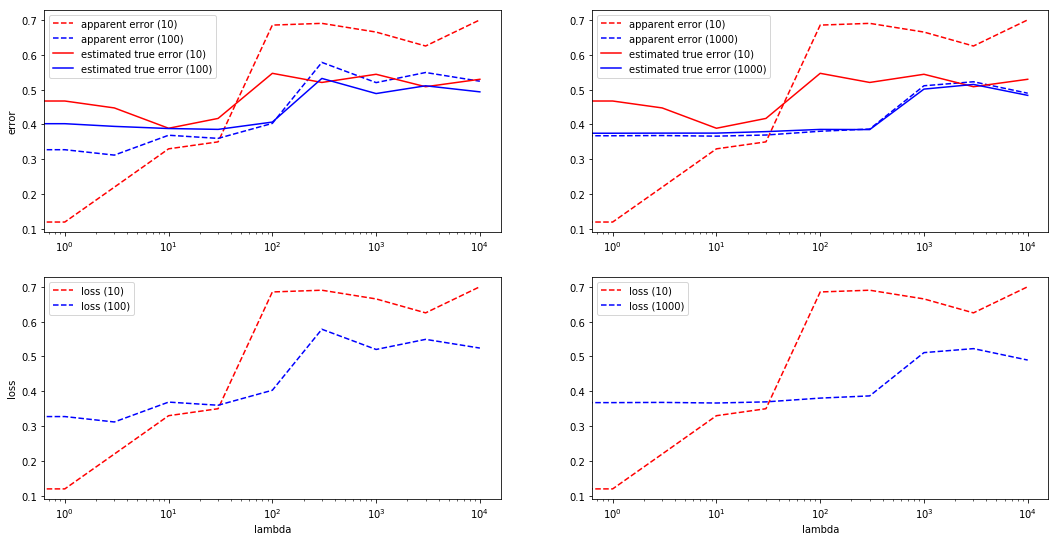

In [11]:
f, ((axs1, axs2), (axs3, axs4)) = plt.subplots(2,2,figsize=(18,9))

plot_error_and_loss(axs1, ylabel=True)
plot_error_and_loss(axs2, n1=10, n2=1000)
plot_error_and_loss(axs3, xlabel=True, ylabel=True, plot_loss=True)
plot_error_and_loss(axs4, n1=10, n2=1000, xlabel=True, plot_loss=True)

plt.show()
f.savefig("error_loss.svg")

In [56]:
def plot_error_bar(ax, n, lamb, ylabel=False):
    plot_x = np.array(('m-','m+'))
    plot_y = [float(torch.mean(m_minus_dict[n][lamb])), float(torch.mean(m_plus_dict[n][lamb]))]
    yerr = [float(torch.std(m_minus_dict[n][lamb])), float(torch.std(m_plus_dict[n][lamb]))]
    
    ax.errorbar(['m-'], plot_y[0], yerr[0], fmt='o', mew=1, capsize=5, ecolor='r', label='m-')
    ax.errorbar(['m+'], plot_y[1], yerr[1], fmt='o', mew=1, capsize=5, ecolor='g', label='m+')
    
    if ylabel:
        ax.set_ylabel('mean of median')
    
    ax.set_xscale('symlog')
    ax.set_title('num of samples: '+ str(n) +', lambda: ' + str(lamb))
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.legend()

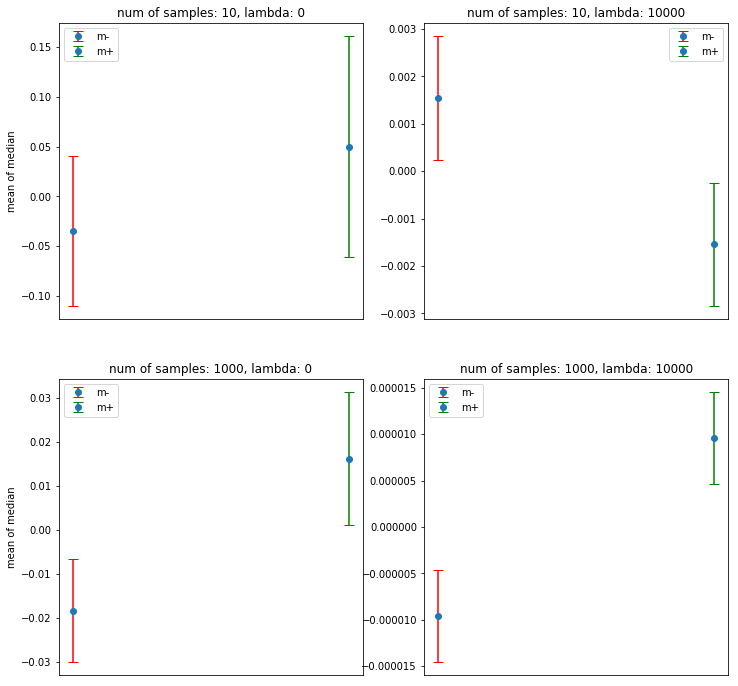

In [57]:
f2, ((axs1, axs2), (axs3, axs4)) = plt.subplots(2,2,figsize=(12,12))
plot_error_bar(ax=axs1, n=10, lamb=0, ylabel=True)
plot_error_bar(ax=axs2, n=10, lamb=10000)
plot_error_bar(ax=axs3, n=1000, lamb=0, ylabel=True)
plot_error_bar(ax=axs4, n=1000, lamb=10000)

f2.savefig('mean_std.svg')